# Machine Learning & Neural Networks Demonstration
***
By [Alejandro Ciuba](https://alejandrociuba.github.io), alejandrociuba@gmail.com
***
## Table of Contents
1. [Scikit Learn's Naive Bayes' Classifier - Austen vs. Melville](#1-scikit-learns-naive-bayes-classifier---austen-vs-melville)
2. [PyTorch (Small Perceptron Model)](#2-pytorch-small-perceptron-model)
3. [Hugging Face Demo](#3-hugging-face-demo)
***
## Necessary Imports
These imports will be used throughout the whole notebook. This code cell should be ran after every restart of the kernel

In [1]:
# General imports
from nltk.corpus import gutenberg
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random as rand

# Scikit Learn
from sklearn.model_selection import train_test_split # We'll use this a lot even though it's an sklearn function
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix

# PyTorch
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn

# Hugging Face
from transformers import pipeline

# Dataset filepath
FILEPATH='./data/'

***
## 1. Scikit Learn's Naive Bayes' Classifier - Austen vs. Melville
Here, we'll revisit the task of labelling a given sentence as either a sentence written by Jane Austen or Herman Melville. However, this time we'll use _Scikit Learn's_ [_Categorical Naive Bayes' Classifier_](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.CategoricalNB.html#sklearn.naive_bayes.CategoricalNB), a NB Classifier tailored to categorical data-labelling tasks.

In [55]:
# First, we need to get the data, the individual sentences
a_sents = [' '.join(sent) for sent in gutenberg.sents('austen-emma.txt')]
m_sents = [' '.join(sent) for sent in gutenberg.sents('melville-moby_dick.txt')]

# Turn it into an np.array
all_sents = np.concatenate([a_sents, m_sents])

# Make an np.array for the labels
all_labels = np.array(['austen'] * len(a_sents) + ['melville'] * len(m_sents))

print(len(all_sents), len(all_labels))
print(all_sents.shape)
print(all_sents[10192], all_labels[10192])
print(type(all_sents))

17776 17776
(17776,)
But now comes the greatest joke of the dream , Flask . melville
<class 'numpy.ndarray'>


In [56]:
# Now, we need to do our train-test split. Conveniently, sklearn has a function just for that
X_train, X_test, y_train, y_test = train_test_split(all_sents, all_labels, test_size=1/3, random_state=0)

print(len(X_train), len(X_test))
print(X_train[314], y_train[314])

11850 5926
But now comes the greatest joke of the dream , Flask . melville


In [57]:
# We need to create a pipeline! This pipeline will automatically tokenize our data and then feed it into the model
nbmodel = make_pipeline(TfidfVectorizer(max_features=1500, stop_words='english'), MultinomialNB())

# Now, we need to train the model by fitting the training data to it. Very simple in sklearn!
nbmodel.fit(X_train, y_train)

nbmodel

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_features=1500, stop_words='english')),
                ('multinomialnb', MultinomialNB())])

Text(0.5, 1.0, 'Heatmap of predicted vs. correct authors\non Austen vs. Melville')

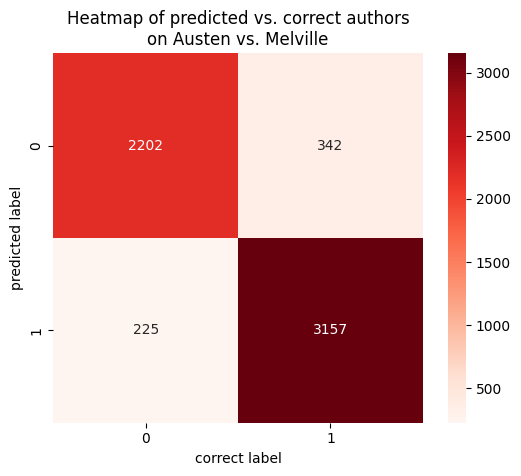

In [61]:
# Now let's test
plabels = nbmodel.predict(X_test)

# Create a heatmap to examine which are right and wrong
mat = confusion_matrix(y_test, plabels)
sns.heatmap(mat, square=True, annot=True, fmt='d', cmap="Reds")
plt.xlabel('correct label')
plt.ylabel('predicted label')
plt.title('Heatmap of predicted vs. correct authors\non Austen vs. Melville')

In [70]:
# Let's try it ourselves
print(nbmodel.predict(["Wow, this was a really cool thing to do and wasn't hard to set up!"]))
print(nbmodel.predict(["I am absolutely crushed Mr. Bayes rejected my invitation to the destruction of the world!"]))
print(nbmodel.predict(["This is Mr. Herman Austen writing. How goes your day, my friend, Queequeg?"])) # Notice how one feature holds a lot of power?

['melville']
['austen']
['melville']


***
## 2. PyTorch (Small Perceptron Model)
This will be a simple _Feed Forward Neural Network_ with fully connected layers (A _Perceptron_). This will demonstrate how neural networks are bad at deterministic tasks like logic operators. Here, we will try to train a neural network to recognize the correct output of a logical operator given two binary numbers (AND, OR, XOR). To create our data, the format will be a vector of length 3 such that:

`[int([0,1]), int([0,1]), int([0,2])]` where the first two numbers are either 0 or 1 and the third corresponds to the logical operator (AND = 0, OR = 1, XOR = 2)

### Doing Things The Old-Fashioned Way

In [51]:
# Function to create output labels (look we did it, lmfao)
def output_old(nums:list, op:int) -> int:
    if op == 0:
        return nums[0] & nums[1]
    elif op == 1:
        return nums[0] | nums[1]
    else:
        return nums[0] ^ nums[1]

# Let's create our training and testing data
size = 10000
num1 = [rand.randint(0, 1) for i in range(size)]
num2 = [rand.randint(0, 1) for i in range(size)]
op = [rand.randint(0, 2) for i in range(size)]
dataset = np.array([[num1, num2, op] for num1, num2, op in zip(num1, num2, op)])
print(dataset.shape)
print(dataset[100])

# Now for the labels
labels = np.array([output_old([data[0], data[1]], data[2]) for data in dataset])
print(labels.shape)
print(dataset[100], labels[100])

(10000, 3)
[0 1 0]
(10000,)
[0 1 0] 0


In [52]:
# Let's split it into our train-test split
X_train, X_test, y_train, y_test = train_test_split(dataset, labels, test_size=1/4, random_state=0)

print(len(X_train), len(X_test))
print(X_train[314], y_train[314])

7500 2500
[0 1 1] 1


### Now For The PyTorch Way

In [35]:
# Create a specialized dataset class to make the training loop easier
# Class also modifed to have transforms
class BinaryOpsDataset(Dataset):
    def __init__(self, n=100, transform=None):

        # Let's create our training and testing data
        self.n = n
        num1 = [rand.randint(0, 1) for i in range(n)]
        num2 = [rand.randint(0, 1) for i in range(n)]
        op = [rand.randint(0, 2) for i in range(n)]
        self.x = np.array([[num1, num2, op] for num1, num2, op in zip(num1, num2, op)])

        # Now for the labels
        self.y = np.array([self.output([data[0], data[1]], data[2]) for data in self.x])

        # And any necessary transformations
        self.transform = transform

    def __len__(self):
        return self.n

    def __getitem__(self, index):

        if self.transform:
            return self.transform((self.x[index], self.y[index]))
        else:
            return self.x[index], self.y[index]

    def output(self, nums:list, op:int) -> int:
        """
        Same function as before, just made a class method.
        """

        if op == 0:
            return int(nums[0]) & int(nums[1])
        elif op == 1:
            return int(nums[0]) | int(nums[1])
        else:
            return int(nums[0]) ^ int(nums[1])

# Create a custom transforms
class ToTensor():
    def __call__(self, sample):
        inputs, targets = sample
        return torch.from_numpy(np.asarray(inputs)), torch.from_numpy(np.asarray(targets))

# Create our dataset, contains data
n = 50000
train_dataset = BinaryOpsDataset(n, transform=ToTensor())
test_dataset = BinaryOpsDataset(n, transform=ToTensor())
print(train_dataset[100])


# Create our dataloader, used to iterate through the training loop more easily
train_dataloader = DataLoader(dataset=train_dataset, batch_size=40, shuffle=True, num_workers=2) # Subprocs
test_dataloader = DataLoader(dataset=test_dataset, batch_size=40, shuffle=True, num_workers=2) # Subprocs

(tensor([0, 0, 0]), tensor(0))


In [36]:
# Now this is where things get a little bit complicated. We need to make a class to store the neural network
# First, here are all the hyperparameters it'll have
# Length of a datapoint
input_size = 3

# How many "nodes" each hidden layer will have, kind of arbitrary without optimization searches
hidden_size = 100

# The number of classes it'll be asked to identify (1)
num_classes = 2

# Learning rate, how quickly it should "accept/learn" new data (the step size of our gradient descent)
learning_rate = .001

# How many epochs (iteration through the entire training data) there are
num_epochs = 6

# Create the Neural Network, a fully connected FFNN (Perceptron)
class Perceptron(nn.Module):

    def __init__(self, input_size, hidden_size, num_classes, /):

        # This is required for any NN class
        super(Perceptron, self).__init__()

        # Create layers
        self.l1 = nn.Linear(input_size, hidden_size)

        # The activation function used between each layer
        self.relu = nn.ReLU()

        self.l2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        """
        This is the function called for a prediction, feeding the data through our model in-order
        """
        
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        return out

# Create our model
model = Perceptron(input_size, hidden_size, num_classes)

# Loss and Optimizer
# Loss is how we calculate the loss (the loss function) and optimizer is an additional step for performance
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [37]:
# Harness GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move model to device
model = model.to(device)

# Training loop
total_samples = len(train_dataset)

# Steps per epoch
n_total_steps = len(train_dataloader)

for epoch in range(num_epochs):
    for i, (logic_ops, labels) in enumerate(train_dataloader):

        # Convert to float32 and push to GPU
        inputs = logic_ops.to(torch.float32).to(device)
        labels = labels.to(device)

        # Forward and Loss        
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward Pass
        optimizer.zero_grad() # Clear grads from last cycle
        loss.backward()
        optimizer.step()

        if (i + 1) % 625 == 0:
            print('epoch: %d/%d, step: %d/%d, loss=%.4ff' % (epoch+1, num_epochs, i+1, n_total_steps, loss.item()))

epoch: 1/6, step: 625/1250, loss=0.0853f
epoch: 1/6, step: 1250/1250, loss=0.0168f
epoch: 2/6, step: 625/1250, loss=0.0074f
epoch: 2/6, step: 1250/1250, loss=0.0043f
epoch: 3/6, step: 625/1250, loss=0.0018f
epoch: 3/6, step: 1250/1250, loss=0.0013f
epoch: 4/6, step: 625/1250, loss=0.0007f
epoch: 4/6, step: 1250/1250, loss=0.0005f
epoch: 5/6, step: 625/1250, loss=0.0004f
epoch: 5/6, step: 1250/1250, loss=0.0002f
epoch: 6/6, step: 625/1250, loss=0.0002f
epoch: 6/6, step: 1250/1250, loss=0.0001f


In [38]:
# Testing
with torch.no_grad():
    n_correct = 0
    n_samples = len(test_dataset)

    for logic_ops, labels in test_dataloader:

        # Convert to float32 and push to GPU
        inputs = logic_ops.to(torch.float32).to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        
        # Rows of vectors, we want the max from the vectors
        # value, index
        _, preds = torch.max(outputs, 1)
        n_samples += labels.shape[0]
        n_correct += (preds == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print('Accuracy=%.4f' % acc)
    
    print(model(torch.tensor([1,1,1], dtype=torch.float32).to(device)))

Accuracy=50.0000
tensor([-4.3848,  4.1469], device='cuda:0')


***
## 3. Hugging Face Demo
This will be just a quick demo on how to use an _NLP-based Hugging Face Pretrained Transformer Model_. They are very easy to use and can be easily added to a given program to give it some more functionality.

### Default Transformers

In [122]:
# First, just a general task but no Transformer specified; defaults to one
classifier = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [123]:
classifier('This is my very first hugging face transformer model. It seems really nice to use!')

[{'label': 'POSITIVE', 'score': 0.9995996356010437}]

### Picking Our Own
The [website](https://huggingface.co) makes this very easy! Let's pick one! The one this notebook is currently using is the [_T5\_Small_](https://huggingface.co/t5-small), but feel free to rewrite to pick your own!

In [124]:
from transformers import AutoTokenizer, AutoModelWithLMHead

tokenizer = AutoTokenizer.from_pretrained("t5-small")

model = AutoModelWithLMHead.from_pretrained("t5-small")

Downloading:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

/home/computer_cat/miniconda3/lib/python3.9/site-packages/transformers/models/t5/tokenization_t5_fast.py:156: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
/home/computer_cat/miniconda3/lib/python3.9/site-packages/transformers/models/auto/modeling_auto.py:1062: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `Auto

Downloading:   0%|          | 0.00/242M [00:00<?, ?B/s]

In [128]:
# There's a lot of documentation on how to use this transformer (https://huggingface.co/docs/transformers/main/en/model_doc/t5#inference)
input_ids = tokenizer("translate English to Romanian: The house is wonderful.", return_tensors="pt").input_ids
outputs = model.generate(input_ids)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

Casa este minunată.
